# NLP

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

### a. GRU

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a gating mechanism to input or forget certain features, but lacks a context vector or output gate, resulting in fewer parameters than LSTM. GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs showed that gating is indeed helpful in general, and Bengio's team came to no concrete conclusion on which of the two gating units was better.

GRU.svg

### b. LSTM

Long short-term memory (LSTM) network is a recurrent neural network (RNN), aimed to deal with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory". It is applicable to classification, processing and predicting data based on time series, such as in handwriting, speech recognition, machine translation, speech activity detection, robot control, video games, and healthcare.

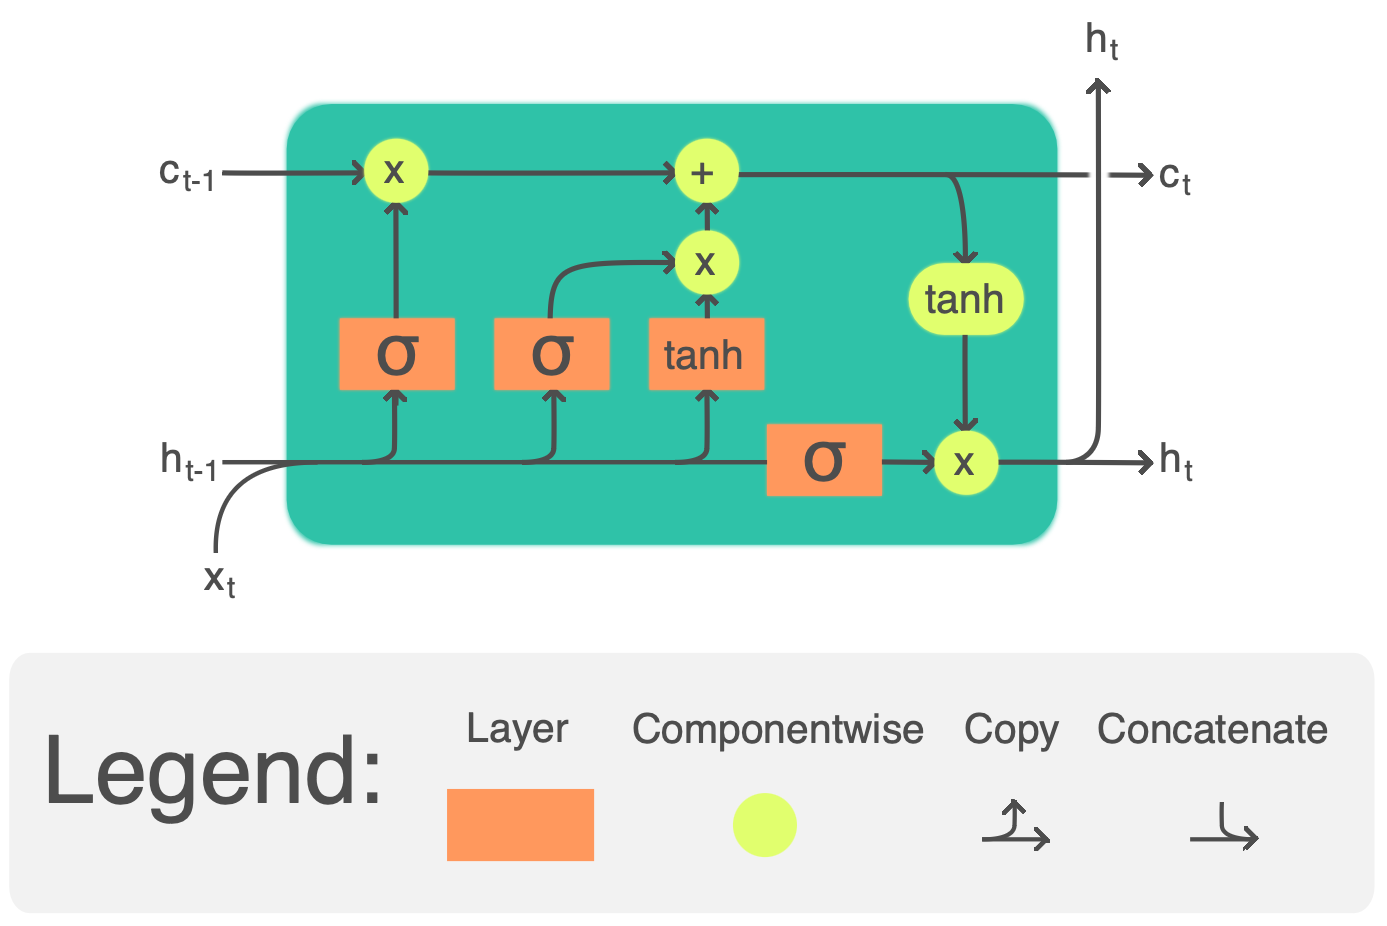

### Input Data

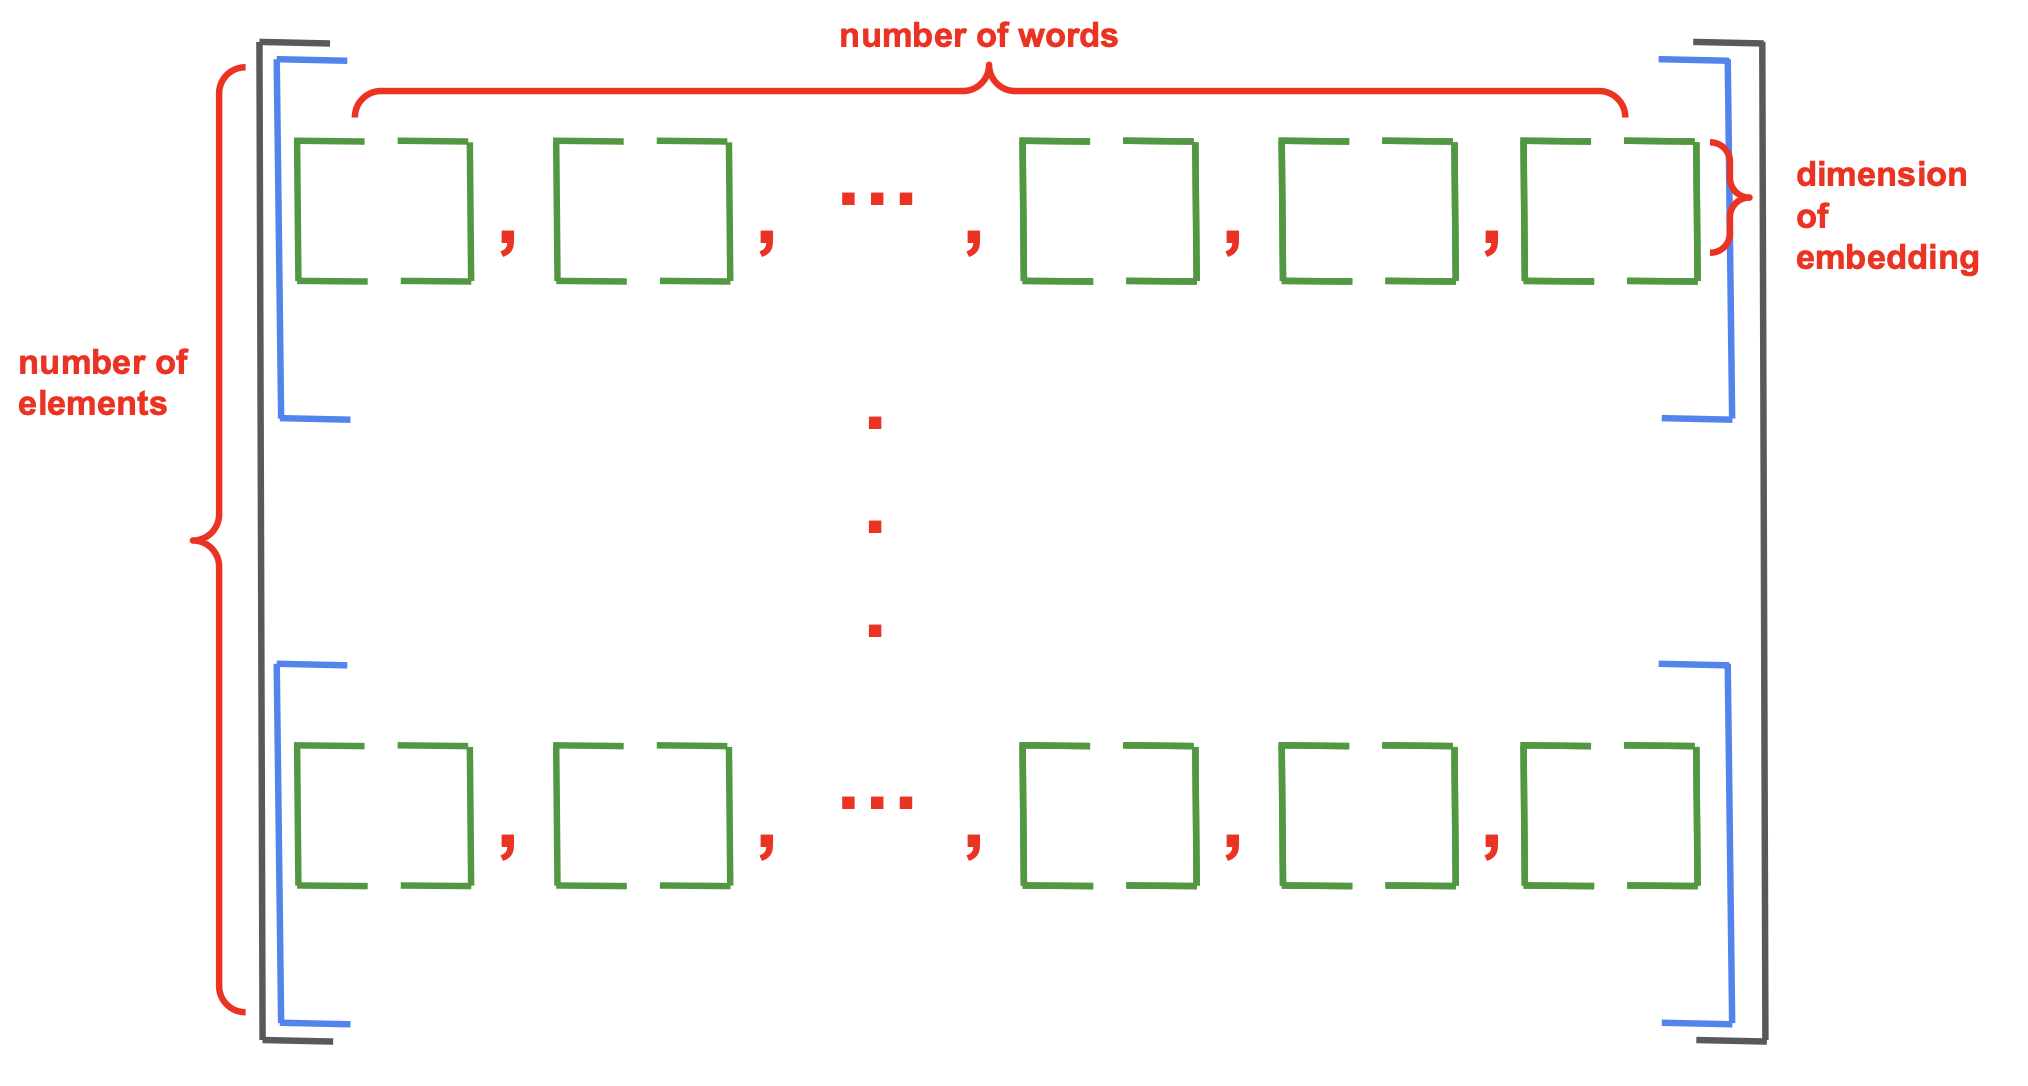

**Data Type at Entry:** Torch tensors.

**Data Type at Output:** Torch tensors.

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

### Start time of execution

In [3]:
start = time.time()

# 1. Read Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = 'drive/MyDrive/Github_Alberto_Valdes/Deep_Learning/NLP/SMSSpamCollection'

In [6]:
with open(path) as file:
  data = file.readlines()

In [7]:
data = [i.split('\t') for i in data]

In [8]:
all_txt = [i[1] for i in data]
label = [i[0] for i in data]

In [9]:
df = pd.DataFrame({'txt': all_txt, 'class': label})

In [10]:
df = df.replace({'class': {'spam': 1, 'ham': 0}})

In [11]:
round(df['class'].value_counts(normalize = True)*100, 2)

0    86.6
1    13.4
Name: class, dtype: float64

We would use techniques for imbalanced datasets, but for now we wont use it.

### i. Remove special characters

In [12]:
signs = []

for i in range(len(data)):

  txt_part = df['txt'].iloc[i]

  for c in txt_part:

    if c.isalpha() == True or c.isdigit() == True:
      pass

    else:

      if (c in signs) == False:
        signs.append(c)

signs.remove(' ')

In [13]:
len(signs)

46

In [14]:
def remove_signs(txt, signs):

  new_txt = ''

  for c in txt:

    if c in signs:
      pass

    else:
      new_txt = new_txt + c

  return new_txt

In [15]:
df['txt'] = df['txt'].map(lambda x: remove_signs(x, signs))

### ii. Lower Case

In [16]:
df['txt'] = df['txt'].map(lambda x: x.lower())

In [17]:
X = df[['txt']].copy()
y = df['class'].copy()

### iii. Split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

### iv. Tokenization

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def txt_to_vec(text, max_len, embedding):

  vec_txt = []

  split_text = text.split(' ')
  split_text = split_text[0: max_len]

  for i in range(max_len):

    try:
      s_t = split_text[i]
      vec_txt.append(embedding[s_t])

    except:
      vec_txt.append(np.zeros(300))

  return vec_txt

In [22]:
def word_2_vec(input_X, input_y, embedding, n_batches, max_len):

  output_X = []
  output_y = []

  h_batches = int(len(input_X)/n_batches) + 1

  for n_batch in range(n_batches):

    input_X_batch = input_X.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]
    input_y_batch = input_y.iloc[n_batch*h_batches: (n_batch + 1)*h_batches]

    out_X = []
    out_y = []

    for i in range(len(input_X_batch)):

      txt_part = input_X_batch['txt'].iloc[i]
      class_part = input_y_batch.iloc[i]

      out_X.append(txt_to_vec(txt_part, max_len, embedding))

      if class_part == 1:

        out_y.append([1, 0])

      else:

        out_y.append([0, 1])

    output_X.append(torch.Tensor(out_X))
    output_y.append(torch.Tensor(out_y))

  return output_X, output_y

In [23]:
import gensim.downloader

In [24]:
%%time

glove_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 6min 11s, sys: 26.9 s, total: 6min 37s
Wall time: 7min 3s


In [25]:
max_len = 40
n_batches_train = 4

In [26]:
X_train_c, y_train_c = word_2_vec(X_train, y_train, glove_vectors, n_batches_train, max_len)

In [27]:
X_val_c, y_val_c = word_2_vec(X_val, y_val, glove_vectors, 1, max_len)

In [28]:
X_test_c, y_test_c = word_2_vec(X_test, y_test, glove_vectors, 1, max_len)

# 2. Creation class NN

In [29]:
from sklearn.metrics import recall_score

In [30]:
class RNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)

        out, h = self.rnn(x, h)

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [31]:
class GRU(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)

        out, h = self.gru(x, h)

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [32]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [33]:
class LSTM_BI(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, device):
        super(LSTM_BI, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.len_words = len_words

        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional = True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*self.len_words*2, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        out = self.logsoftmax(out)

        return out

    def init_hidden(self, batch_size):
        h = torch.zeros(2*self.n_layers, batch_size, self.hidden_dim)
        return h.to(self.device)

In [34]:
class model_NLP:

  def __init__(self, input_size, output_size, hidden_dim, n_layers, len_words, lr, n_epochs, n_batches, device, class_model):

    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.len_words = len_words
    self.lr = lr
    self.n_epochs = n_epochs
    self.n_batches = n_batches

    self.device = device

    self.model = class_model(self.input_size, self.output_size, self.hidden_dim, self.n_layers, self.len_words, self.device)

    self.model = self.model.to(device)


  def evaluate(self, X):

    self.model.train()

    out_eval = self.model(X)
    out_eval = out_eval.cpu().detach().numpy()
    out_eval = np.exp(out_eval)[:, 0]

    return out_eval


  def train(self, X_train_set, y_train_set, X_val_set, y_val_set, verbose = True, graph = True):

    # Define criterion and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)

    start_train = time.time()

    #----------------------------------------------------------------------

    all_loss_train = []
    all_loss_val = []

    all_recall_train = []
    all_recall_val = []

    all_epochs = []

    for epoch in range(1, self.n_epochs + 1):

      #--------------------------------------------------------------------

      start_epoch = time.time()

      #--------------------------------------------------------------------

      # 1. Train epoch

      self.model.train()

      loss_train_epoch = 0
      recall_train_epoch = 0

      for n in range(self.n_batches):

        X_batch = X_train_set[n]
        y_batch = y_train_set[n]

        optimizer.zero_grad() # Clears existing gradients

        out_train_batch = self.model(X_batch)
        loss_train_batch = criterion(out_train_batch, y_batch)

        loss_train_batch.backward()
        optimizer.step() # Updates the weights accordingly

        loss_train_epoch = loss_train_epoch + loss_train_batch.item()/len(X_batch)

        #--------------------------------------------------------------------

        recall_train_batch = recall_score(
            y_batch[:, 0].cpu().detach().numpy(),
            (np.exp(out_train_batch.cpu().detach().numpy())[:, 0] > 0.134)*1,
            average = 'macro'
            )

        recall_train_epoch = recall_train_epoch + recall_train_batch

        #--------------------------------------------------------------------

      #--------------------------------------------------------------------

      loss_train_epoch = loss_train_epoch/self.n_batches

      all_loss_train.append(loss_train_epoch)
      all_epochs.append(epoch)

      recall_train_epoch = recall_train_epoch/self.n_batches
      recall_train_epoch = round(recall_train_epoch*100, 2)

      all_recall_train.append(recall_train_epoch)

      #--------------------------------------------------------------------

      # 2. Evaluate in validation set

      self.model.eval()

      out_val = self.model(X_val_set[0])
      loss_val = criterion(out_val, y_val_set[0])
      loss_val = loss_val.item()/len(X_val_set[0])

      all_loss_val.append(loss_val)

      recall_val = recall_score(
          y_val_set[0][:, 0].cpu().detach().numpy(),
          (np.exp(out_val.cpu().detach().numpy())[:, 0] > 0.134)*1,
          average = 'macro'
      )

      recall_val = round(recall_val*100, 2)
      all_recall_val.append(recall_val)

      #--------------------------------------------------------------------

      end_epoch = time.time()

      #--------------------------------------------------------------------

      if verbose:

        print('Epoch:', epoch)

        print('\n')

        print('Loss Train:', loss_train_epoch)

        print('Loss Val:', loss_val)

        print('\n')

        print('Recall Train:', recall_train_epoch)

        print('Recall Val:', recall_val)

        print('\n')

        print_time_execution(start_epoch, end_epoch, f'Run the epoch.')

        print('\n')

        print('-'*70)

      #--------------------------------------------------------------------

    #--------------------------------------------------------------------

    end_train = time.time()

    print_time_execution(start_train, end_train, f'In training the model')

    print('\n')

    print('-'*70)

    print('\n')

    #--------------------------------------------------------------------

    if graph:

      # i. Loss

      plt.figure(figsize = (10, 7))

      plt.plot(all_epochs, all_loss_train, label = 'Loss Train', color = 'blue')
      plt.plot(all_epochs, all_loss_val, label = 'Loss val', color = 'red')

      plt.title('Loss', fontsize = 17)

      plt.xlabel('Number of epochs', fontsize = 15)
      plt.ylabel('Loss', fontsize = 15)

      plt.legend()

      plt.show()

      print('\n')

      print('\n')

      # ii. Recall

      plt.figure(figsize = (10, 7))

      plt.plot(all_epochs, all_recall_train, label = 'Recall Train', color = 'blue')
      plt.plot(all_epochs, all_recall_val, label = 'Recall val', color = 'red')

      plt.title('Recall', fontsize = 17)

      plt.xlabel('Number of epochs', fontsize = 15)
      plt.ylabel('Recall', fontsize = 15)

      plt.legend()

      plt.show()

    #--------------------------------------------------------------------

# 3. Send sets to device

In [35]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [36]:
for i in range(n_batches_train):

  # Train

  X_train_c[i] = X_train_c[i].to(device)
  y_train_c[i] = y_train_c[i].to(device)

# Validation

X_val_c[0] = X_val_c[0].to(device)
y_val_c[0] = y_val_c[0].to(device)

# Test

X_test_c[0] = X_test_c[0].to(device)
y_test_c[0] = y_test_c[0].to(device)

# 4. Hyperparameter Tuning

In [37]:
all_hidden_dim = [(10*i + 50) for i in range(6)]
all_n_layers = [1, 2]
all_lr = [0.001*i for i in range(1, 5 + 1)]
all_n_epochs = [10*i for i in range(2, 7 + 1)]

### a. RNN

In [38]:
class_model = RNN
start_rnn = time.time()

In [39]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_len, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.134)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Recall val: 93.1


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 60
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 70
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
----------

In [40]:
recall_opt_rnn = all_recall_val[all_recall_val == all_recall_val.max()][0]

params_opt_rnn = all_params[all_recall_val == all_recall_val.max()][0]

hidden_dim_opt_rnn = int(params_opt_rnn[0])
n_layers_opt_rnn = int(params_opt_rnn[1])
lr_opt_rnn = params_opt_rnn[2]
n_epochs_opt_rnn = int(params_opt_rnn[3])

In [41]:
print('Optimal recall:', recall_opt_rnn)
print('Hidden dim (Opt):', hidden_dim_opt_rnn)
print('N layers (Opt):', n_layers_opt_rnn)
print('LR (Opt):', lr_opt_rnn)
print('N epochs (Opt):', n_epochs_opt_rnn)

Optimal recall: 97.24
Hidden dim (Opt): 60
N layers (Opt): 1
LR (Opt): 0.002
N epochs (Opt): 30


In [42]:
end_rnn = time.time()
print_time_execution(start_rnn, end_rnn, f'Tuning the RNN')

'Tuning the RNN it takes 0 hours, 9 mins and 11 segs.'

### b. GRU

In [43]:
class_model = GRU
start_gru = time.time()

In [44]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_len, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.134)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Recall val: 91.03


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 60
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 91.72


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 70
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 91.72


----------------------------------------------------------------------
----------------------------------------------------------------------
---------

In [45]:
recall_opt_gru = all_recall_val[all_recall_val == all_recall_val.max()][0]

params_opt_gru = all_params[all_recall_val == all_recall_val.max()][0]

hidden_dim_opt_gru = int(params_opt_gru[0])
n_layers_opt_gru = int(params_opt_gru[1])
lr_opt_gru = params_opt_gru[2]
n_epochs_opt_gru = int(params_opt_gru[3])

In [46]:
print('Optimal recall:', recall_opt_gru)
print('Hidden dim (Opt):', hidden_dim_opt_gru)
print('N layers (Opt):', n_layers_opt_gru)
print('LR (Opt):', lr_opt_gru)
print('N epochs (Opt):', n_epochs_opt_gru)

Optimal recall: 97.24
Hidden dim (Opt): 70
N layers (Opt): 2
LR (Opt): 0.001
N epochs (Opt): 40


In [47]:
end_gru = time.time()
print_time_execution(start_gru, end_gru, f'Tuning the GRU')

'Tuning the GRU it takes 0 hours, 15 mins and 44 segs.'

### c. LSTM

In [48]:
class_model = LSTM
start_lstm = time.time()

In [49]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_len, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.134)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 60
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 91.72


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 70
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
---------

In [50]:
recall_opt_lstm = all_recall_val[all_recall_val == all_recall_val.max()][0]

params_opt_lstm = all_params[all_recall_val == all_recall_val.max()][0]

hidden_dim_opt_lstm = int(params_opt_lstm[0])
n_layers_opt_lstm = int(params_opt_lstm[1])
lr_opt_lstm = params_opt_lstm[2]
n_epochs_opt_lstm = int(params_opt_lstm[3])

In [51]:
print('Optimal recall:', recall_opt_lstm)
print('Hidden dim (Opt):', hidden_dim_opt_lstm)
print('N layers (Opt):', n_layers_opt_lstm)
print('LR (Opt):', lr_opt_lstm)
print('N epochs (Opt):', n_epochs_opt_lstm)

Optimal recall: 96.55
Hidden dim (Opt): 80
N layers (Opt): 2
LR (Opt): 0.001
N epochs (Opt): 20


In [52]:
end_lstm = time.time()
print_time_execution(start_lstm, end_lstm, f'Tuning the LSTM')

'Tuning the LSTM it takes 0 hours, 18 mins and 53 segs.'

### d. LSTM BI

In [53]:
class_model = LSTM_BI
start_lstm_bi = time.time()

In [54]:
all_recall_val = []
all_params = []

for lr in all_lr:
  for n_layers in all_n_layers:
    for n_epochs in all_n_epochs:
      for hidden_dim in all_hidden_dim:

        print('\n')

        print('Hyperparameters:')

        print('\n')

        print('Hidden dim:', hidden_dim)
        print('N layers:', n_layers)
        print('LR:', lr)
        print('N epochs:', n_epochs)

        print('\n')

        model = model_NLP(300, 2, hidden_dim, n_layers, max_len, lr, n_epochs, n_batches_train, device, class_model)
        model.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = False, graph = False)
        prob_val = model.evaluate(X_val_c[0])

        y_pred_val = (prob_val > 0.134)*1
        y_real_val = np.array(y_val)

        recall_val = recall_score(y_real_val, y_pred_val)
        recall_val = round(recall_val*100, 2)

        print('Recall val:', recall_val)

        all_recall_val.append(recall_val)
        all_params.append([hidden_dim, n_layers, lr, n_epochs])

        print('\n')

        print('-'*70)
        print('-'*70)
        print('-'*70)

all_recall_val = np.array(all_recall_val)
all_params = np.array(all_params)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 60
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 91.72


----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


Hyperparameters:


Hidden dim: 70
N layers: 2
LR: 0.002
N epochs: 60




----------------------------------------------------------------------


Recall val: 92.41


----------------------------------------------------------------------
----------------------------------------------------------------------
---------

In [55]:
recall_opt_lstm_bi = all_recall_val[all_recall_val == all_recall_val.max()][0]

params_opt_lstm_bi = all_params[all_recall_val == all_recall_val.max()][0]

hidden_dim_opt_lstm_bi = int(params_opt_lstm_bi[0])
n_layers_opt_lstm_bi = int(params_opt_lstm_bi[1])
lr_opt_lstm_bi = params_opt_lstm_bi[2]
n_epochs_opt_lstm_bi = int(params_opt_lstm_bi[3])

In [56]:
print('Optimal recall:', recall_opt_lstm_bi)
print('Hidden dim (Opt):', hidden_dim_opt_lstm_bi)
print('N layers (Opt):', n_layers_opt_lstm_bi)
print('LR (Opt):', lr_opt_lstm_bi)
print('N epochs (Opt):', n_epochs_opt_lstm_bi)

Optimal recall: 97.24
Hidden dim (Opt): 80
N layers (Opt): 2
LR (Opt): 0.002
N epochs (Opt): 20


In [57]:
end_lstm_bi = time.time()
print_time_execution(start_lstm_bi, end_lstm_bi, f'Tuning the LSTM BI')

'Tuning the LSTM BI it takes 0 hours, 37 mins and 44 segs.'

# 5. Testing and Calibration

In [58]:
from sklearn.calibration import calibration_curve

In [59]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [60]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')

    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

### a. RNN

In [61]:
class_model = RNN

In [62]:
model_rnn_opt = model_NLP(300, 2, hidden_dim_opt_rnn, n_layers_opt_rnn, max_len, lr_opt_rnn, n_epochs_opt_rnn, n_batches_train, device, class_model)

Epoch: 1


Loss Train: 0.0005891319453223093
Loss Val: 0.0003450237314797303


Recall Train: 50.0
Recall Val: 49.9




----------------------------------------------------------------------
Epoch: 2


Loss Train: 0.00040942926214192346
Loss Val: 0.0002869201882537705


Recall Train: 70.25
Recall Val: 73.14




----------------------------------------------------------------------
Epoch: 3


Loss Train: 0.0003326178576513408
Loss Val: 0.0002132246713467243


Recall Train: 81.43
Recall Val: 86.32




----------------------------------------------------------------------
Epoch: 4


Loss Train: 0.00023503275858179445
Loss Val: 0.00014323022868066625


Recall Train: 90.52
Recall Val: 88.78




----------------------------------------------------------------------
Epoch: 5


Loss Train: 0.00015674712701049915
Loss Val: 0.00010781057613312931


Recall Train: 91.81
Recall Val: 91.06




----------------------------------------------------------------------
Epoch: 6


Loss Train: 0.000127655077

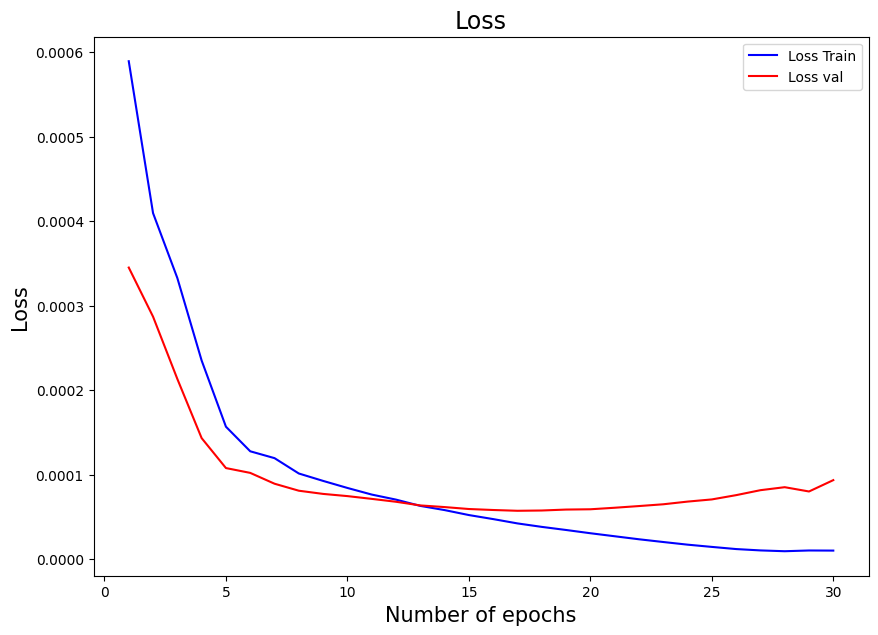

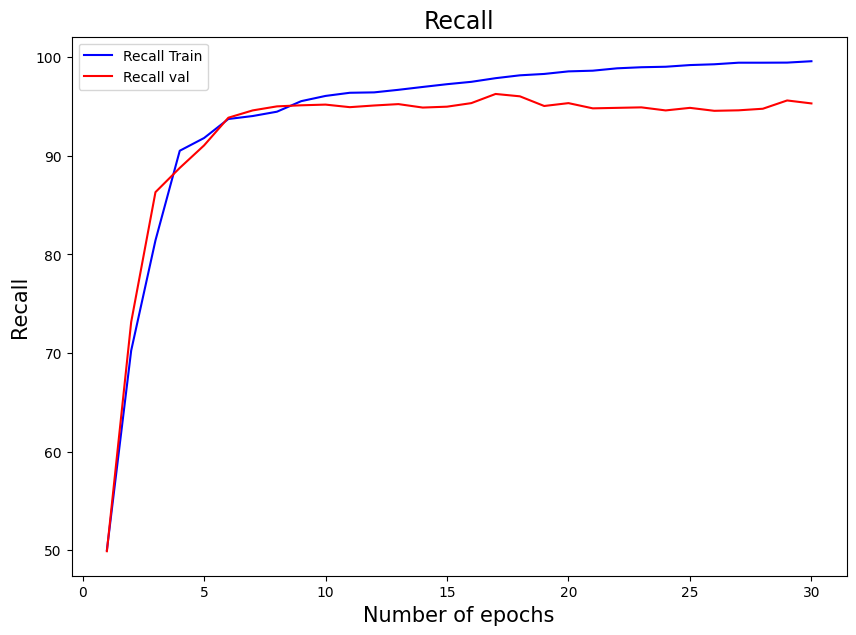

In [63]:
model_rnn_opt.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = True, graph = True)

In [64]:
prob_val = model_rnn_opt.evaluate(X_val_c[0])
y_pred_val = (prob_val > 0.134)*1
y_real_val = np.array(y_val)

prob_test = model_rnn_opt.evaluate(X_test_c[0])
y_pred_test = (prob_test > 0.134)*1
y_real_test = np.array(y_test)

In [65]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 95.17
Precision val: 75.82
F1 val: 84.4
Accuracy val: 95.43


In [66]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 96.77
Precision test: 75.76
F1 test: 84.99
Accuracy test: 95.25


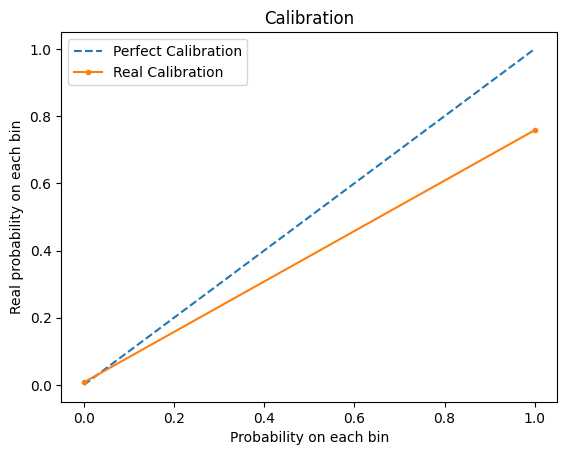

In [67]:
calibration(y_real_val, y_pred_val)

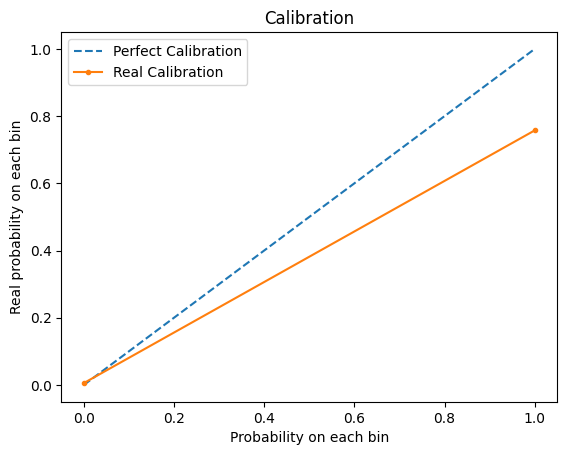

In [68]:
calibration(y_real_test, y_pred_test)

In [69]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [70]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [71]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [72]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [73]:
X_p_c[0] = X_p_c[0].to(device)

In [74]:
out_p = model_rnn_opt.evaluate(X_p_c[0])

In [75]:
round(out_p[0]*100, 4)

0.0026

In [76]:
round(out_p[1]*100, 4)

99.9997

### b. GRU

In [77]:
class_model = GRU

In [78]:
model_gru_opt = model_NLP(300, 2, hidden_dim_opt_gru, n_layers_opt_gru, max_len, lr_opt_gru, n_epochs_opt_gru, n_batches_train, device, class_model)

Epoch: 1


Loss Train: 0.0006407941851902485
Loss Val: 0.0003455054866893409


Recall Train: 50.0
Recall Val: 49.69




----------------------------------------------------------------------
Epoch: 2


Loss Train: 0.00048748299399274615
Loss Val: 0.0003511033785182799


Recall Train: 50.01
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 3


Loss Train: 0.00044389859266925414
Loss Val: 0.0003093209501873752


Recall Train: 62.7
Recall Val: 74.22




----------------------------------------------------------------------
Epoch: 4


Loss Train: 0.0004128247256421047
Loss Val: 0.00028329927290501617


Recall Train: 61.87
Recall Val: 76.03




----------------------------------------------------------------------
Epoch: 5


Loss Train: 0.0003495915974959071
Loss Val: 0.00022882990238377865


Recall Train: 83.77
Recall Val: 87.86




----------------------------------------------------------------------
Epoch: 6


Loss Train: 0.00026521441491

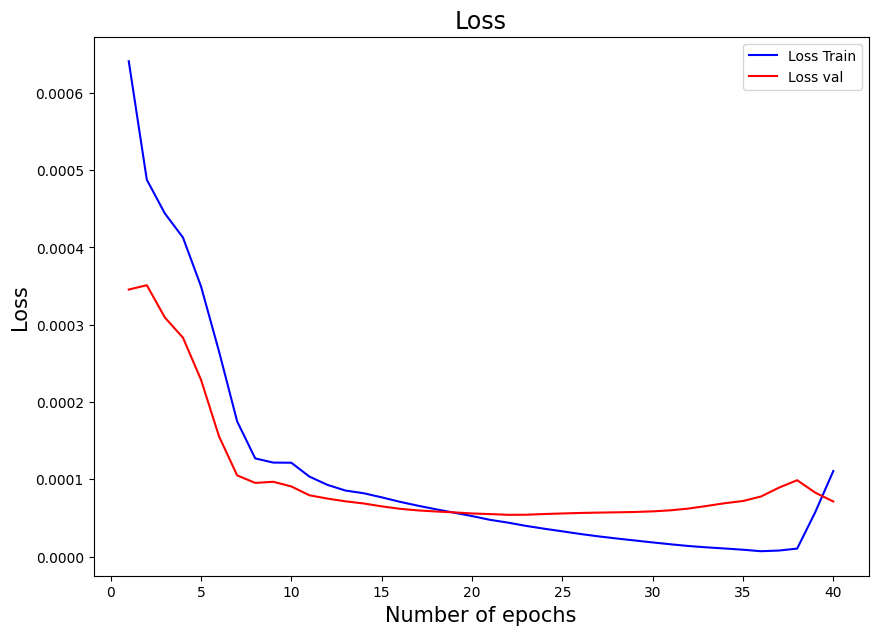

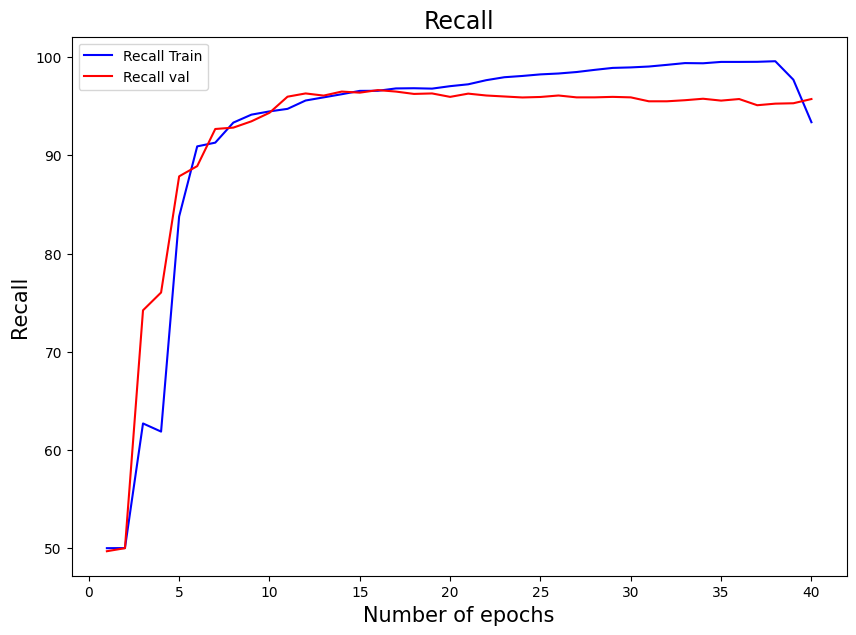

In [79]:
model_gru_opt.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = True, graph = True)

In [80]:
prob_val = model_gru_opt.evaluate(X_val_c[0])
y_pred_val = (prob_val > 0.134)*1
y_real_val = np.array(y_val)

prob_test = model_gru_opt.evaluate(X_test_c[0])
y_pred_test = (prob_test > 0.134)*1
y_real_test = np.array(y_test)

In [81]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 93.1
Precision val: 89.4
F1 val: 91.22
Accuracy val: 97.67


In [82]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 93.55
Precision test: 86.83
F1 test: 90.06
Accuracy test: 97.13


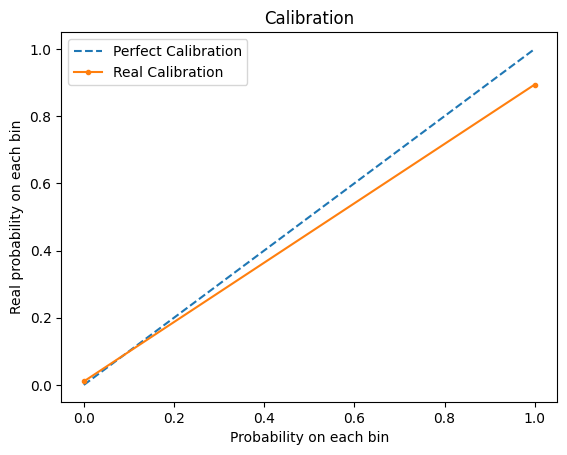

In [83]:
calibration(y_real_val, y_pred_val)

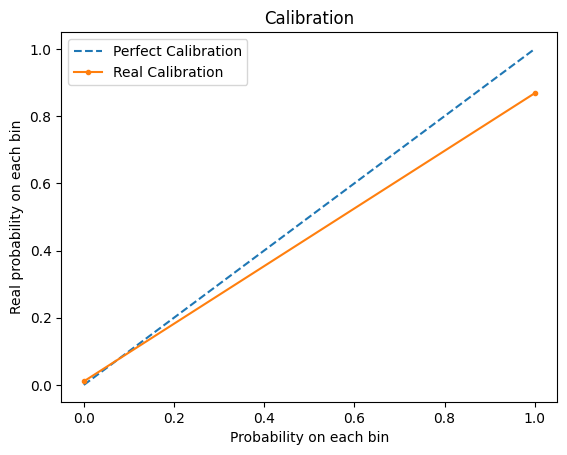

In [84]:
calibration(y_real_test, y_pred_test)

In [85]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [86]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [87]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [88]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [89]:
X_p_c[0] = X_p_c[0].to(device)

In [90]:
out_p = model_gru_opt.evaluate(X_p_c[0])

In [91]:
round(out_p[0]*100, 4)

0.0015

In [92]:
round(out_p[1]*100, 4)

99.9996

### c. LSTM

In [93]:
class_model = LSTM

In [94]:
model_lstm_opt = model_NLP(300, 2, hidden_dim_opt_lstm, n_layers_opt_lstm, max_len, lr_opt_lstm, n_epochs_opt_lstm, n_batches_train, device, class_model)

Epoch: 1


Loss Train: 0.0006828602068718692
Loss Val: 0.00036355035187417615


Recall Train: 50.0
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 2


Loss Train: 0.0004872617513378508
Loss Val: 0.0003738884166751742


Recall Train: 51.38
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 3


Loss Train: 0.0004922089692758672
Loss Val: 0.0003379350553179001


Recall Train: 50.0
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 4


Loss Train: 0.00045068003819373335
Loss Val: 0.00033182194414694747


Recall Train: 61.39
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 5


Loss Train: 0.00044407851927345614
Loss Val: 0.0003174972373808446


Recall Train: 50.0
Recall Val: 50.1




----------------------------------------------------------------------
Epoch: 6


Loss Train: 0.0004075795973148512

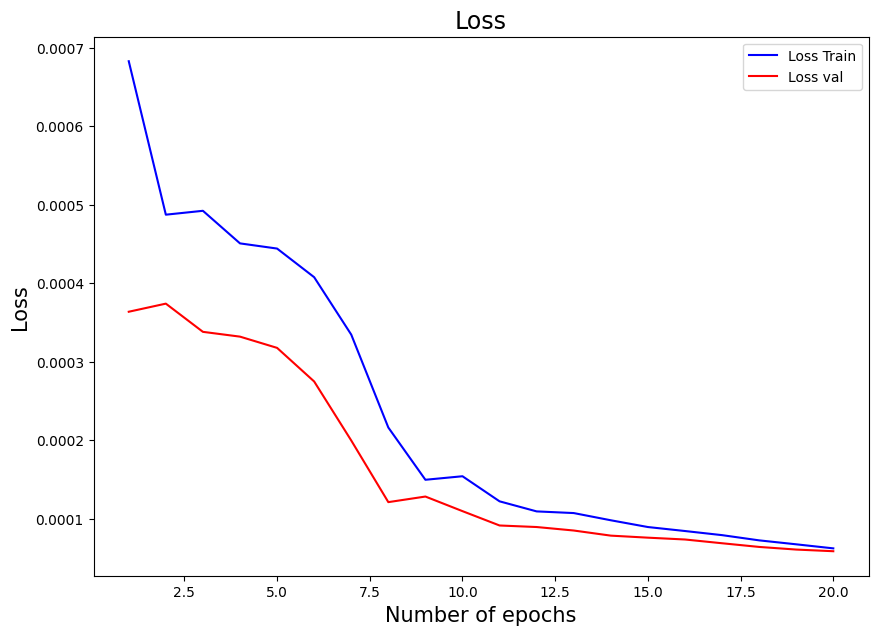

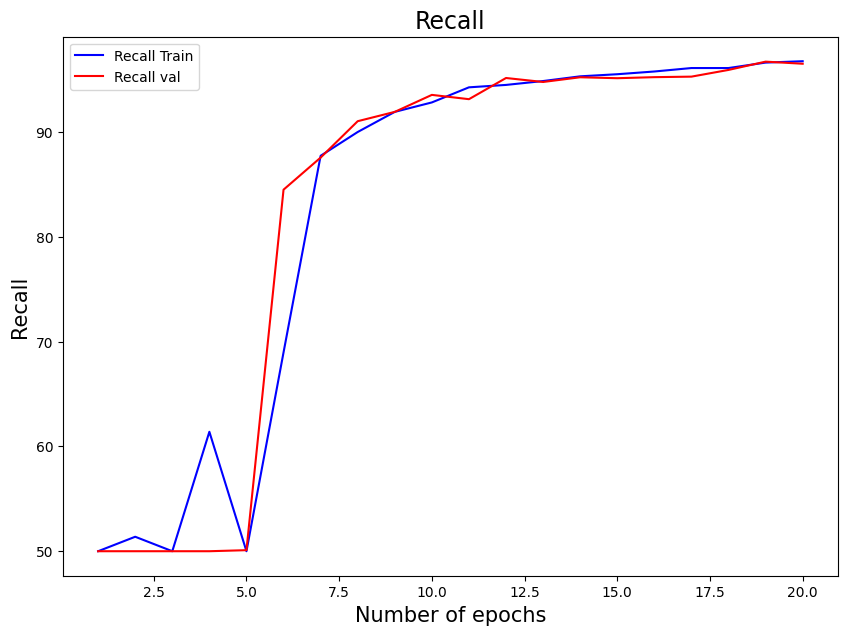

In [95]:
model_lstm_opt.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = True, graph = True)

In [96]:
prob_val = model_lstm_opt.evaluate(X_val_c[0])
y_pred_val = (prob_val > 0.134)*1
y_real_val = np.array(y_val)

prob_test = model_lstm_opt.evaluate(X_test_c[0])
y_pred_test = (prob_test > 0.134)*1
y_real_test = np.array(y_test)

In [97]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 95.86
Precision val: 83.23
F1 val: 89.1
Accuracy val: 96.95


In [98]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 96.13
Precision test: 81.42
F1 test: 88.17
Accuracy test: 96.41


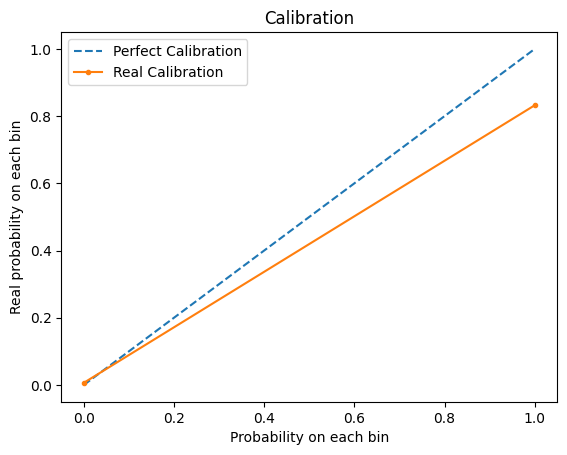

In [99]:
calibration(y_real_val, y_pred_val)

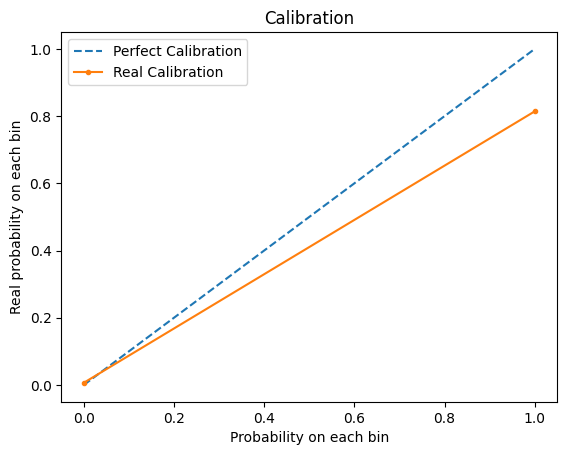

In [100]:
calibration(y_real_test, y_pred_test)

In [101]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [102]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [103]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [104]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [105]:
X_p_c[0] = X_p_c[0].to(device)

In [106]:
out_p = model_lstm_opt.evaluate(X_p_c[0])

In [107]:
round(out_p[0]*100, 4)

0.1859

In [108]:
round(out_p[1]*100, 4)

98.3705

### d. LSTM BI

In [109]:
class_model = LSTM_BI

In [110]:
model_lstm_bi_opt = model_NLP(300, 2, hidden_dim_opt_lstm_bi, n_layers_opt_lstm_bi, max_len, lr_opt_lstm_bi, n_epochs_opt_lstm_bi, n_batches_train, device, class_model)

Epoch: 1


Loss Train: 0.0005879654472855591
Loss Val: 0.00035865886863571645


Recall Train: 50.0
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 2


Loss Train: 0.00045997817311092034
Loss Val: 0.00032301897959858845


Recall Train: 52.49
Recall Val: 50.0




----------------------------------------------------------------------
Epoch: 3


Loss Train: 0.00038856241461718847
Loss Val: 0.00022841705335095323


Recall Train: 74.52
Recall Val: 84.71




----------------------------------------------------------------------
Epoch: 4


Loss Train: 0.0002390712638473849
Loss Val: 0.00011571391815561884


Recall Train: 86.71
Recall Val: 91.16




----------------------------------------------------------------------
Epoch: 5


Loss Train: 0.00015008799400066607
Loss Val: 0.00012256500432309547


Recall Train: 92.78
Recall Val: 93.52




----------------------------------------------------------------------
Epoch: 6


Loss Train: 0.0001538729

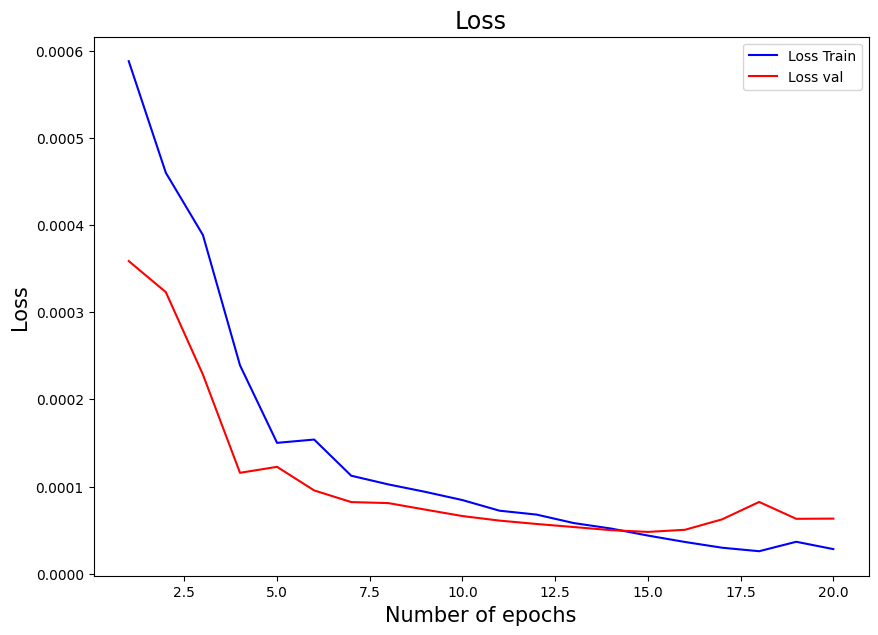

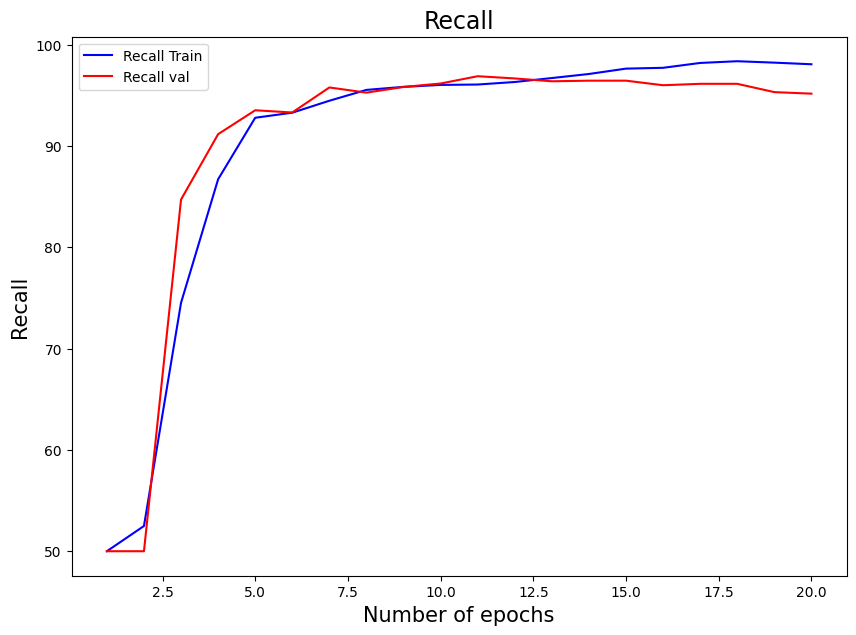

In [111]:
model_lstm_bi_opt.train(X_train_c, y_train_c, X_val_c, y_val_c, verbose = True, graph = True)

In [112]:
prob_val = model_lstm_bi_opt.evaluate(X_val_c[0])
y_pred_val = (prob_val > 0.134)*1
y_real_val = np.array(y_val)

prob_test = model_lstm_bi_opt.evaluate(X_test_c[0])
y_pred_test = (prob_test > 0.134)*1
y_real_test = np.array(y_test)

In [113]:
print('Recall val:', round(recall_score(y_real_val, y_pred_val)*100, 2))
print('Precision val:', round(precision_score(y_real_val, y_pred_val)*100, 2))
print('F1 val:', round(f1_score(y_real_val, y_pred_val)*100, 2))
print('Accuracy val:', round(accuracy_score(y_real_val, y_pred_val)*100, 2))

Recall val: 91.03
Precision val: 94.96
F1 val: 92.96
Accuracy val: 98.21


In [114]:
print('Recall test:', round(recall_score(y_real_test, y_pred_test)*100, 2))
print('Precision test:', round(precision_score(y_real_test, y_pred_test)*100, 2))
print('F1 test:', round(f1_score(y_real_test, y_pred_test)*100, 2))
print('Accuracy test:', round(accuracy_score(y_real_test, y_pred_test)*100, 2))

Recall test: 92.9
Precision test: 92.9
F1 test: 92.9
Accuracy test: 98.03


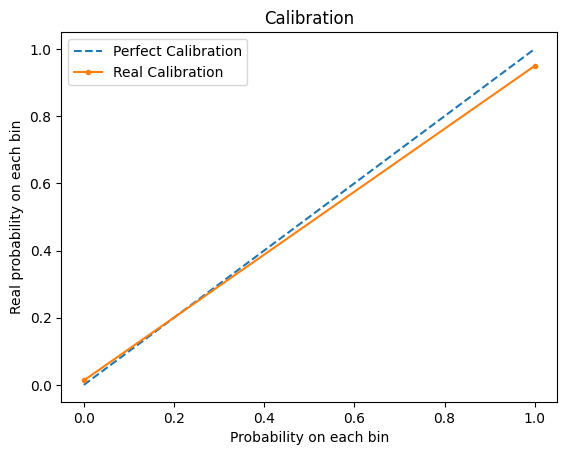

In [115]:
calibration(y_real_val, y_pred_val)

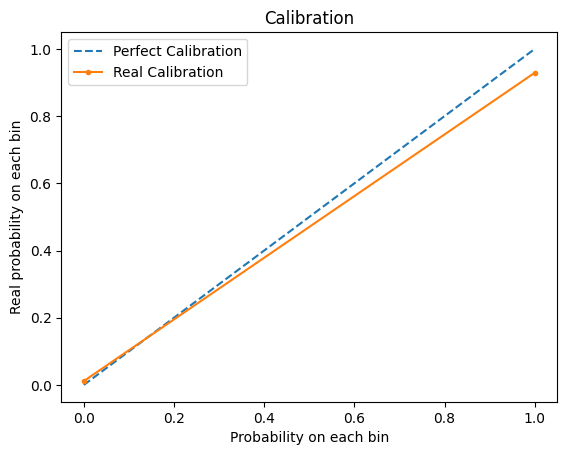

In [116]:
calibration(y_real_test, y_pred_test)

In [117]:
msge_1 = 'Hi Rodrigo! How are you? I hope you very well. Hey dude I invite you to my party!'
msge_2 = 'SUPPORT CHILE !! Send a message to 3311 with the word " Chile " to show your support to your football selection'

In [118]:
df_p = pd.DataFrame({'txt': [msge_1, msge_2], 'class': [0, 1]})

In [119]:
X_p = df_p[['txt']]
y_p = df_p['class']

In [120]:
X_p_c, y_p_c = word_2_vec(X_p, y_p, glove_vectors, 1, max_len)

In [121]:
X_p_c[0] = X_p_c[0].to(device)

In [122]:
out_p = model_lstm_bi_opt.evaluate(X_p_c[0])

In [123]:
round(out_p[0]*100, 4)

0.0317

In [124]:
round(out_p[1]*100, 4)

99.9914

### End time of execution

In [125]:
end = time.time()

In [126]:
print(print_time_execution(start, end, 'notebook execution'))

notebook execution it takes 1 hours, 29 mins and 55 segs.
